Need to make graphics I've described as:

[Pic of correlated 2D multivariate normal]

[Pic of correlated joint overlayed with initialized product]

[Pics of mean field iterating using the overlays]

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import multivariate_normal, norm
from scipy.optimize import minimize

In [2]:
mu_pm = [5,4] # means of intractable distributions
sigma_pm = np.array([[5,2],[2,3]]) # COV of intractable distributions

multi_norm = multivariate_normal(mu_pm, sigma_pm)

red_map = plt.cm.get_cmap("autumn")
blue_map = plt.cm.get_cmap("winter")

In [3]:
num_eval = 100
x_eval = np.linspace(-5,10, num_eval)
y_eval = np.linspace(-5,10, num_eval)

Pm = np.array([np.nan]*(len(x_eval)*len(y_eval))).reshape(len(x_eval),len(y_eval))

# Our intractable distribution is DEFINED by this grid of values. Not the multivariate normal!
for i, xi in enumerate(x_eval):
    for j, yj in enumerate(y_eval):
        Pm[i,j] = multi_norm.pdf([xi,yj])
        
Pm = Pm/np.sum(Pm)

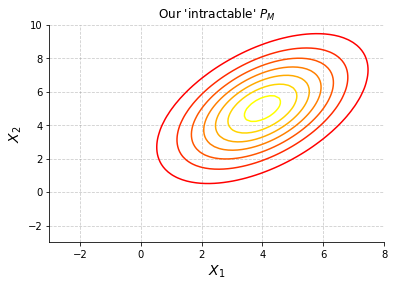

In [4]:
def clean_ax(ax):
    ax.grid(linestyle='--',color='grey',alpha=.4)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('$X_1$',fontsize=14)
    ax.set_ylabel('$X_2$',fontsize=14)
    ax.set_ylim(-3,10)
    ax.set_xlim(-3,8)

def start_fig():
    fig, ax = plt.subplots()
    clean_ax(ax)
    ax.contour(xv, yv, Pm, cmap=red_map)
    return fig, ax

xv, yv = np.meshgrid(x_eval, y_eval)
fig, ax = start_fig()
ax.set_title("Our 'intractable' $P_M$")
fig.savefig('VI_PM.png', dpi=200)

In [5]:
def make_Q_probs(u1, sig1, u2, sig2):
    q1 = norm(u1,np.sqrt(sig1))
    q2 = norm(u2,np.sqrt(sig2))
    
    q1_vals = q1.pdf(x_eval).reshape(-1,1)
    q2_vals = q2.pdf(y_eval).reshape(1,-1)
    Q_vals = q1_vals.dot(q2_vals)
    return Q_vals/np.sum(Q_vals)

def KL(Q,P):
    return np.sum(Q*np.log(Q/P))

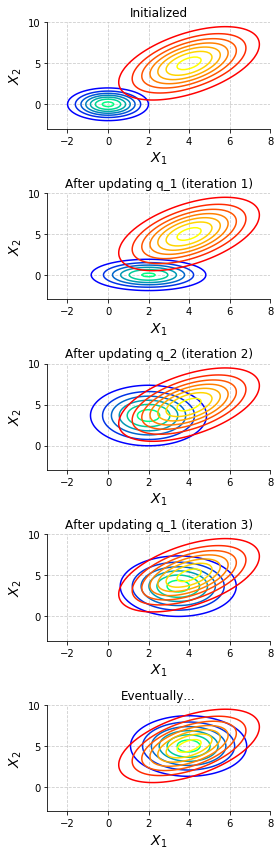

In [6]:
total_iters = 10
iters = 0
do1 = False
u1, sig1, u2, sig2 = 0, 1, 0, 1

num_plots = 5

fig, axarr = plt.subplots(num_plots, 1, figsize=(4, 12))
Q_vals = make_Q_probs(u1, sig1, u2, sig2)
axarr[iters].contour(xv, yv, Q_vals, cmap=blue_map)
axarr[iters].contour(xv, yv, Pm, cmap=red_map)
axarr[iters].set_title('Initialized')
clean_ax(axarr[iters])

while iters < total_iters:
    
    if do1:
        
        def objective(x):
            Q_vals = make_Q_probs(x[0], x[1], u2, sig2)
            return KL(Q_vals,Pm)
        
        u1, sig1 = minimize(objective, np.array([0,1]), method = 'L-BFGS-B', bounds = [[-10,10],[-100,100]]).x 
        
    else:
        
        def objective(x):
            Q_vals = make_Q_probs(u1, sig1, x[0], x[1])
            return KL(Q_vals,Pm)
        
        u2, sig2 = minimize(objective, np.array([0,1]), method = 'L-BFGS-B', bounds = [[-10,10],[-100,100]]).x
        
    iters += 1
    if iters < (num_plots - 1):
        Q_vals = make_Q_probs(u1, sig1, u2, sig2)
        axarr[iters].contour(xv, yv, Q_vals, cmap=blue_map)
        axarr[iters].contour(xv, yv, Pm, cmap=red_map)
        if not do1:
            axarr[iters].set_title('After updating q_1 (iteration {})'.format(iters))
        else:
            axarr[iters].set_title('After updating q_2 (iteration {})'.format(iters))
        clean_ax(axarr[iters])
    
    do1 = not do1
    
Q_vals = make_Q_probs(u1, sig1, u2, sig2)
axarr[num_plots-1].contour(xv, yv, Q_vals, cmap=blue_map)
axarr[num_plots-1].contour(xv, yv, Pm, cmap=red_map)
axarr[num_plots-1].set_title('Eventually...')
clean_ax(axarr[num_plots-1])

fig.tight_layout()
fig.savefig('VI_iterations.png', dpi=200)